## basics

- references
    - https://github.com/pytorch/examples/tree/main/reinforcement_learning
    - https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f
    - https://lilianweng.github.io/posts/2018-04-08-policy-gradient/

### Policy gradient

- REINFORCE: noisy gradients & high variance (of gradients)
    - update the policy parameter ($\theta$) through Monte Carlo updates (i.e. taking random samples)
    - This introduces in inherent high variability in 
        - log probabilities (log of the policy distribution): $\log\pi_\theta(𝑎_𝑡|𝑠_𝑡)$
        - cumulative reward values: $G_t$
    - because each trajectories during training can deviate from each other at great degrees.
- cumulative reward == 0
    - The essence of policy gradient is increasing the probabilities for “good” actions and decreasing those of “bad” actions in the policy distribution;
    - both “goods” and “bad” actions with will not be learned if the cumulative reward is 0.

$$
\nabla_\theta J(\theta)=\mathbb E_\tau[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t|s_t)G_t]
$$

### introduce a baseline $b(s)$

$$
\nabla_\theta J(\theta)=\mathbb E_\tau[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t|s_t)(G_t-b(s_t))]
$$

### Actor Critic

- AC
    - Actor: $\pi(a|s)$
    - Critic: $Q(s, a)$
- Critic
    - estimates the value function.
        - action-value: $Q$ value
        - state-value: $V$ value
            - average general action value at the given state
    - $Q_w(s_t,a_t)$ => Critic neural network，回归一个 value 值；
        - Q Actor Critic
- Actor
    - The policy gradient method is also the “actor” part of Actor-Critic methods 

- both the Critic and Actor functions are parameterized with neural networks. 


$$
\begin{split}
\nabla_\theta J(\theta)&=\mathbb E_\tau[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t|s_t)G_t]\\
&=\mathbb E_{s_0,a_0,\cdots,s_t,a_t}[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t|s_t)] \mathbb E_{r_{t+1},s_{t+1},\cdots,r_T,s_T}[G_t]\\
&=\mathbb E_{s_0,a_0,\cdots,s_t,a_t}[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t|s_t)] Q(s_t,a_t)\\
&=\mathbb E_\tau[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t|s_t) Q_w(s_t,a_t)]
\end{split}
$$

### subtract baseline

$$
A(s_t,a_t) = Q_w(s_t,a_t)-V_v(s_t)
$$

- using the V function as the baseline function, 
- we subtract the $Q$ value term with the $V$ value.
- how much better it is to take a specific action compared to the average, general action at the given state. 
    - **advantage value**

$$
\begin{split}
&Q(s_t,a_t)=\mathbb E[r_{t+1}+\gamma V(s_{t+1})]\\
&A(s_t,a_t)=r_{t+1}+\gamma V_v(s_{t+1})-V_v(s_t)
\end{split}
$$

### Advantage Actor Critic (A2C)

$$
\begin{split}
\nabla_\theta J(\theta)&=\mathbb E_\tau[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t|s_t) (Q_w(s_t,a_t)-V_v(s_t))]\\
&=\mathbb E_\tau[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t|s_t) A(s_t,a_t)]\\
&=\mathbb E_\tau[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t|s_t) \left(r_{t+1}+\gamma V_v(s_{t+1})-V_v(s_t)\right)]\\
&\sim \sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t|s_t)A(s_t,a_t)
\end{split}
$$

## implemention

In [4]:
#!pip install -U gym==0.15.3

In [1]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 300
max_episodes = 3000

In [3]:
env = gym.make("CartPole-v0")

# 4-d 连续
num_inputs = env.observation_space.shape[0]
# 左右离散
num_actions = env.action_space.n
env.reset()

array([0.00262747, 0.04244922, 0.03201457, 0.0220412 ])

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size):
        super(ActorCritic, self).__init__()
        self.num_actions = num_actions
        
        # num_inputs: shape of state
        # critic nn: state => value
        self.critic_ln1 = nn.Linear(num_inputs, hidden_size)
        self.critic_ln2 = nn.Linear(hidden_size, 1)
        
        # actor nn: state => action, policy
        self.actor_ln1 = nn.Linear(num_inputs, hidden_size)
        self.actor_ln2 = nn.Linear(hidden_size, num_actions)
        
    def forward(self, state):
        # (4, ) => (1, 4)
        # ndarray => Variable
        # state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        state = torch.tensor(state, requires_grad=True, dtype=torch.float32).unsqueeze(0)
        
        # forward of critic network
        # (1, 4) => (1, 256)
        value = F.relu(self.critic_ln1(state))
        # (1, 256) => (1, 1)
        value = self.critic_ln2(value)
        
        # (1, 4) => (1, 256)
        policy_dist = F.relu(self.actor_ln1(state))
        # (1, 256) => (1, 2)
        policy_dist = F.softmax(self.actor_ln2(policy_dist), dim=1)
        return value, policy_dist

In [19]:
ac = ActorCritic(num_inputs, num_actions, hidden_size, )  
ac_opt = optim.Adam(ac.parameters(), lr=learning_rate)

In [20]:

# len == max_episodes
all_rewards = []
all_steps = []
ma_steps = []

for episode in range(max_episodes):
    
    # same length
    # index means timestamp: t
    log_probs = [] 
    values = []
    rewards = []
    entropy_term = 0
    
    state = env.reset()
    
    for step in range(num_steps):
        value, policy_dist = ac(state)
        
#         print(value.shape, value)
#         print(policy_dist.shape, policy_dist)
        
        value = value.detach().numpy()[0, 0]
        dist = policy_dist.detach().numpy()
        
#         print(value.shape, value)
#         print(dist.shape, dist)
        
        # 概率化地选择，[0/1]
        action = np.random.choice(num_actions, p=np.squeeze(dist))
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        
        new_state, reward, done, _ = env.step(action)
        
        rewards.append(reward)
        values.append(value)
        log_probs.append(log_prob)
        
        entropy_term += -np.sum(dist * np.log(dist))
#         print(dist, np.log(dist), entropy_term)
        
        state = new_state
        
        if done or step == num_steps - 1:
            q_value, _ = ac(new_state)
            q_value = q_value.detach().numpy()[0, 0]
            all_rewards.append(np.sum(rewards))
            all_steps.append(step)
            ma_steps.append(np.mean(all_steps[-10:]))
            if episode % 100 == 0:
                print(f'episode: {episode}, reward: {np.sum(rewards)}, steps: {step}, average steps: {ma_steps[-1]}')
            break
                
    # 收集训练数据
    q_values = np.zeros_like(values)
    for t in range(len(values))[::-1]:
        # discounted reward
        # 只跟 final value 有关
        q_value = rewards[-1] + GAMMA * q_value
        q_values[t] = q_value
    
    values = torch.FloatTensor(values)
    q_values = torch.FloatTensor(q_values)
    log_probs = torch.stack(log_probs)
#     print(values.shape, q_values.shape, log_probs.shape)
    advantage = q_values - values
    
    # scalar objective to minimize
    actor_loss = -(log_probs*advantage).mean()
    critic_loss = 0.5*advantage.pow(2).mean()
    loss = actor_loss + critic_loss + 0.001*entropy_term
    
    ac_opt.zero_grad()
    loss.backward()
    ac_opt.step()

episode: 0, reward: 15.0, steps: 14, average steps: 14.0
episode: 100, reward: 28.0, steps: 27, average steps: 29.9
episode: 200, reward: 38.0, steps: 37, average steps: 47.9
episode: 300, reward: 42.0, steps: 41, average steps: 34.3
episode: 400, reward: 53.0, steps: 52, average steps: 33.8
episode: 500, reward: 59.0, steps: 58, average steps: 70.3
episode: 600, reward: 74.0, steps: 73, average steps: 82.4
episode: 700, reward: 47.0, steps: 46, average steps: 114.2
episode: 800, reward: 181.0, steps: 180, average steps: 134.0
episode: 900, reward: 110.0, steps: 109, average steps: 119.2
episode: 1000, reward: 200.0, steps: 199, average steps: 143.2
episode: 1100, reward: 99.0, steps: 98, average steps: 108.0
episode: 1200, reward: 173.0, steps: 172, average steps: 152.3
episode: 1300, reward: 179.0, steps: 178, average steps: 128.4
episode: 1400, reward: 200.0, steps: 199, average steps: 130.3
episode: 1500, reward: 162.0, steps: 161, average steps: 132.8
episode: 1600, reward: 84.0, 

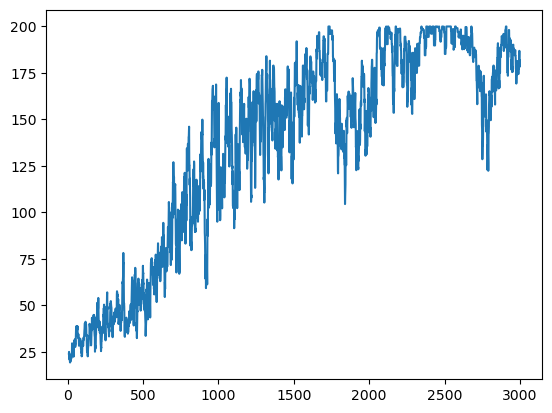

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
ma_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
plt.plot([r for r in ma_rewards])
# plt.plot(all_rewards)
# plt.plot()